# Определение факторов успешности видеоигр

Нам предоставлена база интернет-магазина «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).

**Основная цель - выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.**

Данные за период до 2016 года. Сейчас конец 2016 г., и планируется кампания на 2017-й. Нужно отработать принцип работы с данными.

База представляет собой одну таблицу из 11 колонок: название игры, платформа, год выпуска игры, жанр, продажи в четырёх регионах (Северная Америка, Европа, Япония и другое), рейтинг критиков, рейтинг пользователей и возрастные ограничения игры. В базе 16 715 строк.

В работе используются t-тесты, коэффициенты корреляции и критерий значимости Хи-квадрат, чтобы описать связи между признаками. Проведён подробный графический анализ переменных. Используются библиотеки pandas, numpy, matplorlib, scipy.

## Чтение базы данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

Читаем файл. Заранее оговорим, что в базе особый разделитель в данных - ",", укажем его в качестве аргумента. Десятые доли отображаются корректно, поэтому аргумент decimals при чтении данных опустим.

In [2]:
df = pd.read_csv('games.csv', sep= ',')
display(df)
df.info()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В базе всего 11 переменных и 16715 случаев для анализа. Для дальнейшей работы необходимо обработать пропуски, выбросы и ошибочные значения.

База явно составлена автоматически, без ручного ввода данных, поэтому пропуски здесь не вызываны человеческим фактором. Основной объем пропусков - в рейтингах критиков и пользователей (не все игры получают такие оценки или не все игры получают эти оценки на каком-то портале, который предоставил базу данных) и в возрастных ограничениях (ESRB - американская организация и игры, выпущенные в Японии для домашнего рынка и соседних регионов, эту оценку не будут получать). Поэтому данные можно считать достаточно полными.

## Предварительная подготовка данных для анализа

### Замена названия столбцов

Названия столбцов не соответствуют стандарту PEP8, переименуем их.

In [3]:
df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Обработка пропусков

Посмотрим на пропуски. В переменной имени их два:

In [4]:
df.loc[df['name'].isnull() == True]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Исследуемая база данных - база игр, поэтому отсутствие названия игры может является по сути отсутствием данных. Восстановить эти данные невозможно, тем более они за 1993 год, а для прогноза кампании на 2017 год нам необходимы данные за более поздние периоды. Удалим эти строки таблицы.

In [5]:
df = df.dropna(subset = ['name'])
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Посмотрим на значения переменной платформы, на которой выпущена игра.

In [6]:
df['platform'].value_counts()

PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
NES       98
GB        98
DC        52
GEN       27
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: platform, dtype: int64

Здесь нет ошибок и пропусков. Перейдём к переменной года выпуска игры.

In [7]:
df['year_of_release'].value_counts()

2008.0    1427
2009.0    1426
2010.0    1255
2007.0    1197
2011.0    1136
2006.0    1006
2005.0     939
2002.0     829
2003.0     775
2004.0     762
2012.0     653
2015.0     606
2014.0     581
2013.0     544
2016.0     502
2001.0     482
1998.0     379
2000.0     350
1999.0     338
1997.0     289
1996.0     263
1995.0     219
1994.0     121
1993.0      60
1981.0      46
1992.0      43
1991.0      41
1982.0      36
1986.0      21
1989.0      17
1983.0      17
1990.0      16
1987.0      16
1988.0      15
1985.0      14
1984.0      14
1980.0       9
Name: year_of_release, dtype: int64

Здесь выбросов нет, однако существенное количество игр не имеет данных по году выпуска. Год можно восстановить по платформе, на которой вышла игра, т.к. срок жизни платформы небольшой. Посмотрим, как различаются средние года выхода игр в зависимости от платформ.

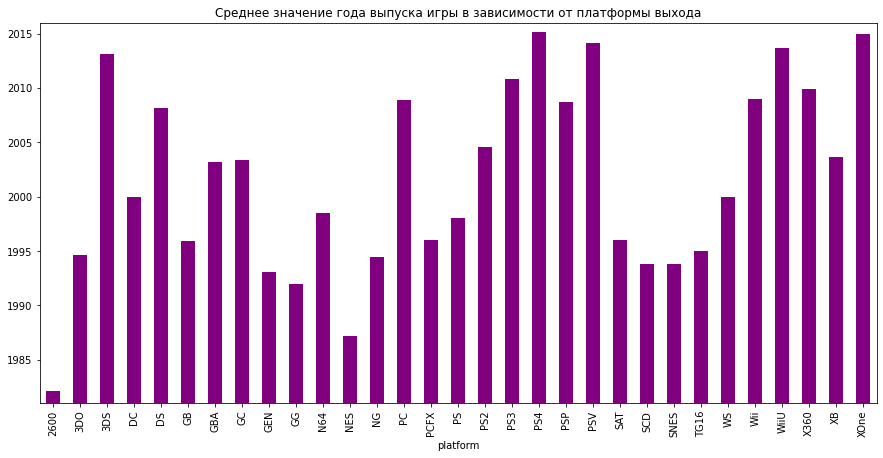

In [8]:
(df
.groupby(by='platform')['year_of_release']
.mean()
.plot(
    kind = 'bar',
    ylim = (1981,2016),
    color = 'purple',
    figsize = (15,7)))
plt.title('Среднее значение года выпуска игры в зависимости от платформы выхода')
plt.show()

Средние различаются существенно. Т.к. нам принципиально сохранить данные по всем играм, заполним год выхода игры средним значением выпуска всех игр на данной платформе.

In [9]:
df['year_of_release'] = df['year_of_release'].fillna(df.groupby('platform')['year_of_release'].transform('mean'))
df['year_of_release'].isna().sum()

0

Пропуски заполнены, посмотрим на вариативность переменной жанров игр.

In [10]:
df['genre'].value_counts()

Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: genre, dtype: int64

Ошибок нет. Посмотрим на переменные объемов продаж.

In [11]:
df.loc[:,'na_sales':'other_sales'].describe()

,na_sales,eu_sales,jp_sales,other_sales
count,16713.000000,16713.000000,16713.000000,16713.000000
mean,0.263302,0.145045,0.077625,0.047343
std,0.813565,0.503359,0.308871,0.186742
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.080000,0.020000,0.000000,0.010000
75%,0.240000,0.110000,0.040000,0.030000
max,41.360000,28.960000,10.220000,10.570000


Пропусков нет, отрицательных значений тоже. Запомним, что есть игры с крайне высокими значениями по показателям продаж.

Далее переменная рейтинга критиков.

In [12]:
print(df['critic_score'].describe())
df['critic_score'].isnull().sum()

count    8137.000000
mean       68.967679
std        13.938165
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64


8576

Критических значений нет, однако в половине случаев рейтинг от критиков отсутствует. Что ж, в базе присутствуют как крупные, так и мелкие релизы, возможно, которые не были замечены экспертами, поэтому данные о рейтинге игр от тематических изданий отсутствуют. Вряд ли их можно восстановить по косвенным признакам, оставим пропуски как есть.

В переменной рейтинга игр от пользователей есть нечисловые значения, поэтому получить описательные статистики не получится:

In [13]:
df['user_score'].describe()

count     10014
unique       96
top         tbd
freq       2424
Name: user_score, dtype: object

Данные есть для большинства игр, но и пропусков много.

In [14]:
df['user_score'].isnull().sum()

6699

Оставим пропуски как есть, т.к. у нас недостаточно данных для их заполнения. Среди заполненных данных четверть - "tbd":

In [15]:
df.query("user_score == 'tbd'")['user_score'].count()

2424

Скорее всего речь об играх, рейтинг которых есть, но [оценок пользователей настолько мало](https://en.wikipedia.org/wiki/To_be_announced), что говорить о наличии такого рейтинга нецелесообразно, т.к. он может быть занижен или завышен из-за высокой погрешности таких данных. По сути это пропуски. Чтоб в дальнейшем работать с переменной как с рядом чисел, а не текстовых значений, нам нужно заменить значения tbd на числа или пропуски, второе будет корректнее.

In [16]:
df['user_score'] = df.query("user_score != 'tbd'")['user_score']
df['user_score'].value_counts()

7.8    324
8      290
8.2    282
8.3    254
8.5    253
      ... 
1.5      2
0.3      2
1.1      2
0        1
9.7      1
Name: user_score, Length: 95, dtype: int64

Сумма пропусков по данной переменной увеличилась:

In [17]:
df['user_score'].isnull().sum()

9123

Последняя переменная - возрастной рейтинг ассоциации ESRB. Здесь тоже в половине случаев пропуски, но мы оставим их как есть за неимением переменных, по которым можно было бы эти значения восстановить или доступа к сторонним базам данных.

In [18]:
df['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

Согласно [перечню используемых рейтингов](https://ru.wikipedia.org/wiki/Entertainment_Software_Rating_Board) К-А - это раннее название рейтинга Е, эти значения нужно заменить на Е. А RP - это отсутствие рейтинга на момент выхода игры или на момент сбора данных, т.е. по сути это пропуски.

In [19]:
df['rating'] = df['rating'].replace('K-A','E')
df['rating'] = df.query("rating != 'RP'")['rating']
df['rating'].value_counts()

E       3993
T       2961
M       1563
E10+    1420
EC         8
AO         1
Name: rating, dtype: int64

Все пропуски и ошибочные значения мы обработали, дубликатов в данных нет.

In [20]:
df.duplicated().sum()

0

### Преобразование типов данных

Год выпуска игры можно заменить на целые числа (предварительно округлив, т.к. ранее мы заполняли пропуски средними значениями), в силу того, что он не принимает дробных значений, а пользовательский рейтинг - на дробные числа, чтобы считать по ним статистики.

In [21]:
df = df.round({'year_of_release': 0})
df = df.astype({'user_score': 'float16', 'year_of_release': 'int16'})
df.dtypes

name                object
platform            object
year_of_release      int16
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float16
rating              object
dtype: object

### Расчёт суммарных продаж во всех регионах

В базе есть продажи в миллионах копий в отдельных регионах. Создадим переменную с суммарными продажами по миру в целом.

In [22]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df['total_sales'].describe()

count    16713.000000
mean         0.533315
std          1.548282
min          0.000000
25%          0.060000
50%          0.170000
75%          0.470000
max         82.540000
Name: total_sales, dtype: float64

Ранее мы видели, что какая-то игра продана на 40 млн копий в Северной Америке, теперь максимум по всему миру - 80 млн копий, т.е. скорее всего, это та же игра, данные посчитаны корректно. Посмотрим, что это за игра.

In [23]:
df.sort_values(by='total_sales', ascending=False).head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.000000,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.296875,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.000000,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


Wii Sports - базовая игра, которая [поставлялась бесплатно ](https://abcnews.go.com/Technology/GadgetGuide/story?id=2662149)с покупкой приставки, поэтому число проданных копий - это число проданных приставок.

### Вывод

В ходе предварительной обработки данных мы прошли следующие этапы работы:
1. Удалили 2 стоки в таблице, где не было указано название игры.
2. Заполнили год выпуска 269 игр средними значениями года выпуска игр на соответствующей платформе, т.к. год выпуска существенно меняется в зависимости от платформы (срок жизни платформы ограничен).
3. Удалили 2424 значения пользовательского рейтинга игры "tbd", т.к. это по сути пропуск.
4. Заменили в 3 случаях возрастную категорию К-А на Е, т.к. это старое обозначение данной категории. В 3 случаях заменили возрастную категорию RP на пропуски, т.к. этот рейтинг ставится демо-играм на момент презентации игры, т.е. на момент попадания в базу у данных игр не было категории.
5. Добавили новую переменную - суммарные продажи по всем регионам.

## Исследовательский анализ данных

### Динамика выпуска игр в разные годы 

Посмотрим на предоставленные данные по годам.

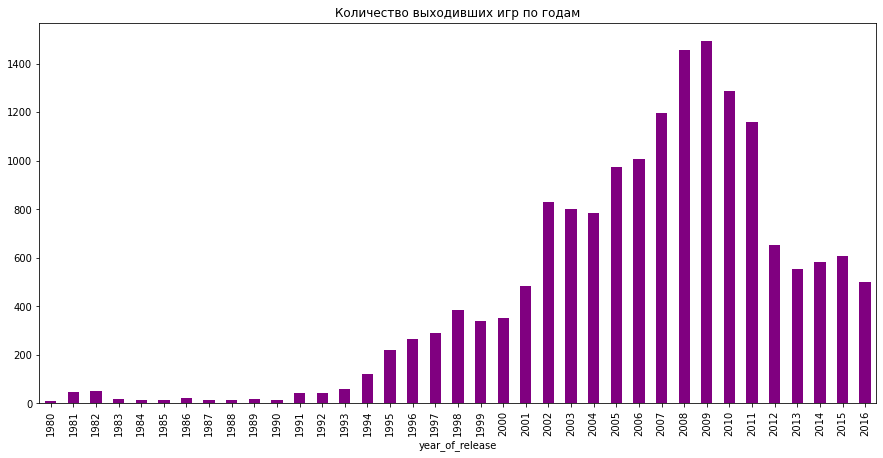

In [24]:
(df
 .groupby('year_of_release')['year_of_release']
 .count()
 .plot(
    kind = 'bar',
    color = 'purple',
    figsize = (15,7)))
plt.title('Количество выходивших игр по годам')
plt.show()

Рынок появился в середине 90-х с развитием 3D-графики. Если считать выход игры на каждой платформе за единицу, что имеет смысл, т.к. часто для портирования игры на какую-либо консоль уходят годы, то мы увидим резкий скачок в 2002 году и резкое падение в 2012 году. [В конце 2001 года вышла новая платформа - X-Box](https://habr.com/ru/company/miip/blog/312884/), и стала одной из основных. По сути для каждой игры теперь увеличилось количество платформ, на которых необходимо делать релиз и, возможно, само количество игр увеличилось не так драматично.

В 2011-2012 году также происходит смена поколений платформ. Новые приставки выпускают и Sony, и Microsoft. Игр (коммерчески успешных и значимых) становится меньше, но они становятся масштабнее.

Посмотрим, как изменится выпуск игр по годам, если убрать дублирование игр на разных платформах.

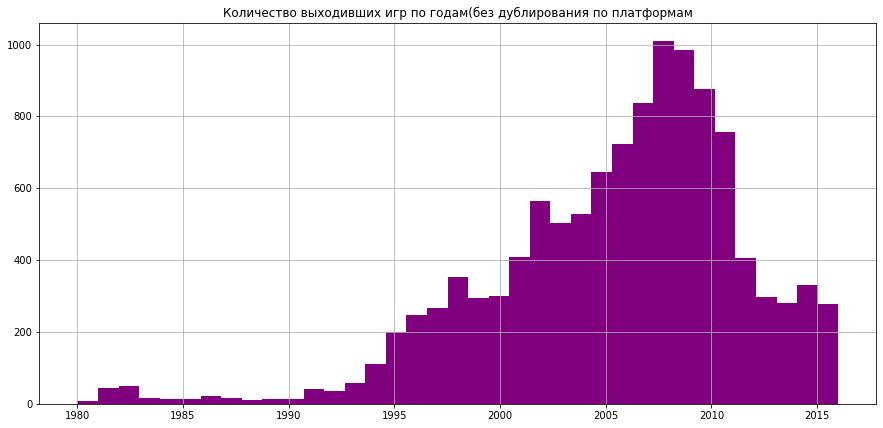

In [25]:
table_by_years = (df.drop_duplicates(subset=['name']))


table_by_years['year_of_release'].hist(
    bins = 37,
    color = 'purple',
    figsize = (15,7))
plt.title('Количество выходивших игр по годам(без дублирования по платформам')
plt.show()

Если анализировать игры по названиям и годам (вне дублирования по платформам), то скачок в 2002 году не становится не так принципиален, а падение в 2012-м всё равно заметно. Основная причина падения рынка по количеству игр - [развитие мобильных игр](https://www.visualcapitalist.com/50-years-gaming-history-revenue-stream/) (на Android и iOS, которые не были учтены в данной базе). По сути они поглотили аркадные игры на мобильных платформах.

В дальнейшем нам необходимо отказаться от части данных. Пока предположим, что рынок в его понимании на 2016 год сформировался в 2010-2012 году.

### Изменение продаж по платформам

Посмотрим на распределение игр по количеству релизов по годам по платформам. Для этого нам понадобится промежуточная таблица с количеством релизов на каждой платформе в каждый год, по которой мы посмотрим диаграмму. На горизонтальной оси будут годы, на вертикальной - платформы, окружностями будут релизы на пересечении года и платформы. Размер окружности соответствует количеству релизов.

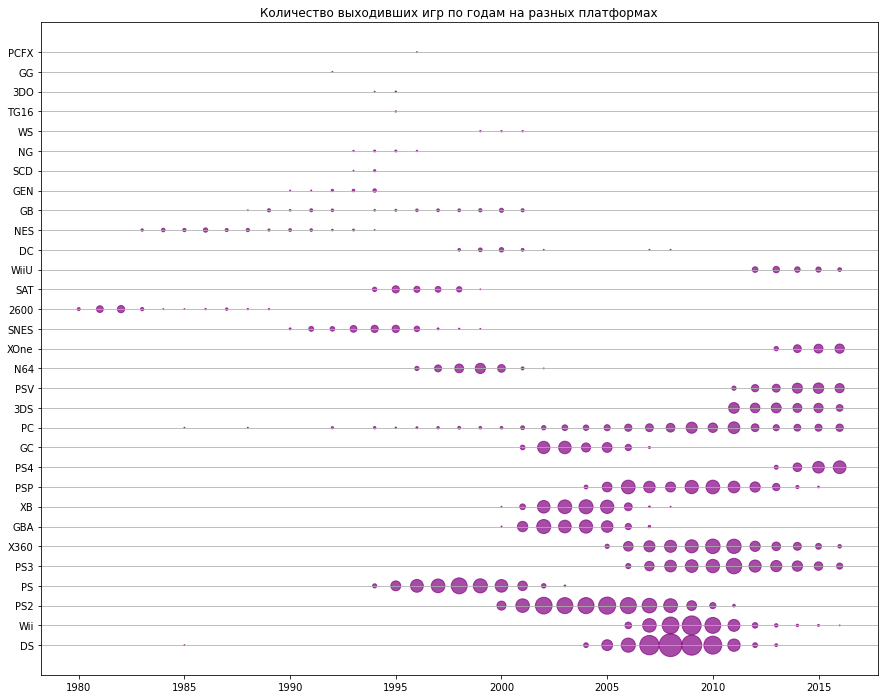

In [26]:
platforms_by_years = (df
                      .groupby('platform')['year_of_release']
                      .value_counts()
                      .sort_values(ascending=False)
                      .to_frame(name='count')
                      .reset_index())


plt.figure(figsize=(15, 12))
plt.scatter(
    platforms_by_years['year_of_release'],
    platforms_by_years['platform'],
    s=platforms_by_years['count'],
    color='purple',
    alpha=0.7)
plt.grid(axis='y')
plt.title('Количество выходивших игр по годам на разных платформах')
plt.show()

Очевидно, что в 2011 году рынок сильно поменялся (мы отмечали это ранее, анализируя только количество игр). Но теперь очевидно, что этот год стал рубежом как для ухода с рынка целого ряда платформ (Wii, DS, PS2), так и для появления крайне сильных игроков (XOne, PSV, 3DS, PS4).

Также ранее мы обращались к [стороннему анализу рынка](https://www.visualcapitalist.com/50-years-gaming-history-revenue-stream/), где 2011 год стал рубежом для взрывообразного развития рынка мобильных игр, что существенно поменяло индустрию, и консоли сосредоточились на более редких, но крупных релизах.

Наиболее интересные данные расположены внизу таблицы. Однако мы оставили все платформы для отображения, чтобы показать, что цикл жизни платформы - примерно 5-6 лет. Так происходит как с небольшими платформами (GEN, DC, WiiU, SAT, N64), так и с крупными (GC, XB, GBA, Wii и DS). Посмотрим на медиану продолжительности жизни платформ:

In [27]:
crosstab_platforms_by_years = pd.crosstab(
    df['year_of_release'],
    df['platform'],
    values= df['platform'],
    aggfunc='count')

list = []
for _ in crosstab_platforms_by_years.columns:
    average = crosstab_platforms_by_years[_].count()
    list.append(average)
pd.Series(list).median()

7.0

Медиана длительности существования платформы на рынке - 7 лет.

### Определение актуального периода анализа 

Итак, мы определили, что для дальнейшего анализа будем использовать данные 2011-2016 годов, посмотрим на объём этих данных.

In [28]:
df_11_16 = df.query('year_of_release > 2010')
print('Всего записей', len(df_11_16))
print('Всего игр', len(df_11_16['name'].unique()))
print('Всего платформ', len(df_11_16['platform'].unique()))

Всего записей 4056
Всего игр 2446
Всего платформ 12


Для формирования дальнейших выводов мы будем работать с новым набором данных с 2011 по 2016 год.

### Определение потенциально прибыльных платформ 

Посмотрим на продажи по платформам за последние 5 лет по всему миру.

In [29]:
df_11_16_by_platforms = (df_11_16.pivot_table(
    index=['year_of_release'],
    columns='platform',
    values='total_sales',
    aggfunc='sum')

.round(0)
.sort_values(by=2016, axis='columns', ascending=False)
.reset_index())


df_11_16_by_platforms

platform,year_of_release,PS4,XOne,3DS,PC,WiiU,PS3,PSV,X360,Wii,DS,PS2,PSP
0,2011,NaN,NaN,63.0,35.0,NaN,165.0,5.0,144.0,60.0,26.0,0.0,18.0
1,2012,NaN,NaN,51.0,23.0,18.0,107.0,16.0,100.0,22.0,11.0,NaN,8.0
2,2013,26.0,19.0,58.0,12.0,22.0,113.0,11.0,89.0,9.0,2.0,NaN,3.0
3,2014,100.0,54.0,44.0,13.0,22.0,48.0,12.0,35.0,4.0,NaN,NaN,0.0
4,2015,119.0,60.0,28.0,9.0,16.0,17.0,6.0,12.0,1.0,NaN,NaN,0.0
5,2016,69.0,26.0,15.0,5.0,5.0,4.0,4.0,2.0,0.0,NaN,NaN,NaN


Похоже, что в 2017 году уже вряд ли прибыльными платформами будут PSP, PS2, DS, Wii, X360, PS3, PSV. Также имеют существенный объем продаж, но уже заканчивают свой жизненный цикл WiiU и классические игры на PC. Вряд ли в базе учтены онлайн-игры на PC, т.к. судя по стороннему анализу рынка этот сегмент только растёт. Таким образом, наиболее прибыльными можно считать три платформы восьмого поколения: PS4, XOne и 3DS. Посмотрим на динамику их продаж более на диаграмме.

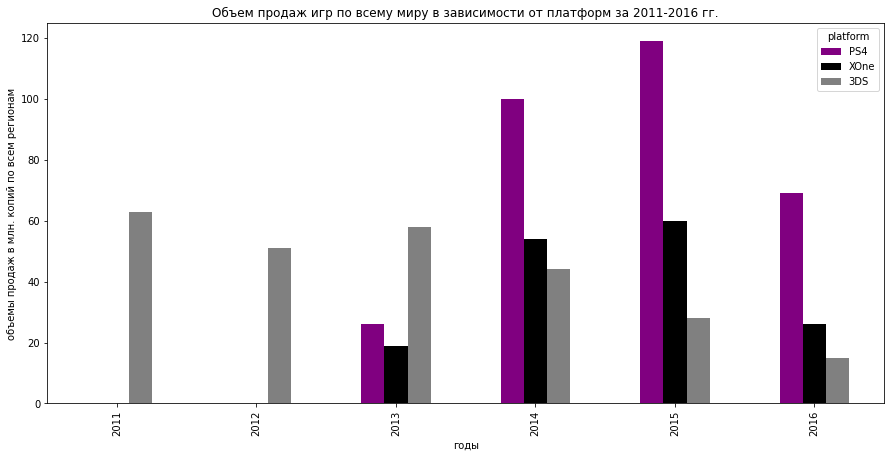

In [30]:
df_11_16_by_platforms.plot(
    x='year_of_release', y=['PS4', 'XOne', '3DS'], kind='bar',  color = ['purple','black','grey'],
    figsize = (15,7)
)
plt.title('Объем продаж игр по всему миру в зависимости от платформ за 2011-2016 гг.')
plt.xlabel('годы')
plt.ylabel('объемы продаж в млн. копий по всем регионам')
plt.show()

За 2016 год данные неполные, поэтому о падении речь не идёт.

PS4 появилась на рынке в 2013 г. и явно сохранит лидерские позиции по итогу 2016 г. и в 2017 г., игры на этой платформе необходимо включить в рекламную кампанию.

XOne вышла параллельно с PS4, развиваласьмедленнее, но линамика 2013-2015 положительная. Эта консоль вполне может поспорить за лидерство в 2017 г. при наличии эксклюзивов, поэтому игры на данной платформе также необходимо включать в рекламную кампанию.

Платформа 3DS появилась раньше, в 2011 г. Её динамику можно описать как стагнирующую, в 2013-2015 было плавное сокращение объемов продаж. Тем не менее, игры на этой платформе занимают третье место на рынке, есть смысл не отказываться от самых перспективных из них.

Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.

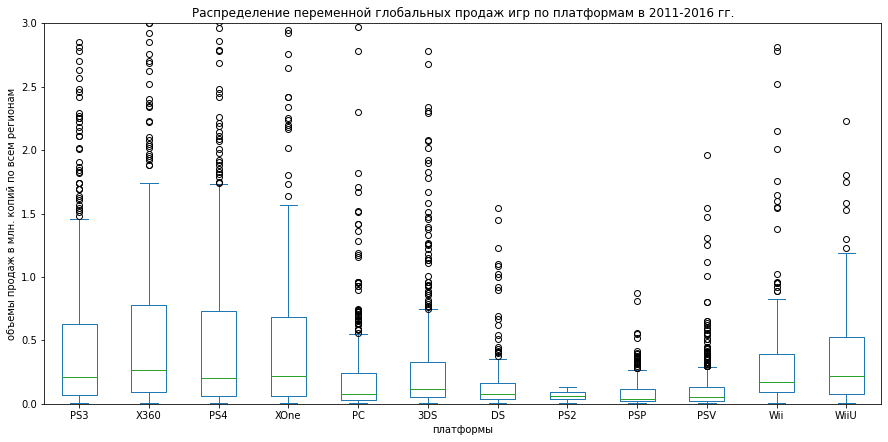

In [31]:
df_11_16_by_names = (df_11_16.pivot_table(
    index=['name'],
    columns='platform',
    values='total_sales',
    aggfunc='sum')

.sort_values(by='Grand Theft Auto V', axis='columns', ascending=False)
)

import warnings
warnings.simplefilter('ignore')

df_11_16_by_names.plot.box(figsize = (15,7), ylim = (0,3))
plt.title('Распределение переменной глобальных продаж игр по платформам в 2011-2016 гг.')
plt.xlabel('платформы')
plt.ylabel('объемы продаж в млн. копий по всем регионам')
plt.show()

Платформы отсортированы по продажам GTA V, т.к. это самая популярная игра в 2011-2016 гг. Максимальные значения продаж доходят до 20 миллионов копий, но мы показываем шкалу до 3 миллионов, чтобы была лучше видна разница между медианами продаж на платформах.

Наибольшая медиана и межквартильный размах - у платформы X360, однако, как мы говорили ранее, эта платформа уже практически покинет рынок в 2017 году. Аналогичная ситуация с патформами PS3, Wii и WiiU: несмотря на высокие значения медиан, они не являются существенными конкурентами.

В 2017 году за лидерство будут спорить PS4 и XOne. У PS4 существенно больше "выбросов" (крайне высоких продаж эксклюзивных игр), однако сама медиана на XOne выше. На PS4 выходит больше игр, однако в среднем продажи игр на XOne выше.

Успешность PS4 на фоне продаж XOne вызвана большим количеством экслюзивных игр, есть ряд технических характеристик, по которым данная приставка лидирует в 2016 году, лояльность аудитории выше.

### Анализ зависимости продаж от отзывов

Отзывы пользователей и критиков есть примерно в половине случаев. Чтобы проанализировать связь отзывов и продаж, необходимо выбрать одну платформу. Посмотрим, какова доля игр, у которых есть рейтинго пользователей и оценка критиков среди общего количества игр по имеющимся платформам.

In [32]:
df_11_16_rating_numer = df_11_16.pivot_table(
    index=['platform'],
    values=['critic_score','user_score','name'],
    aggfunc='count').reset_index()

df_11_16_rating_numer['critic_score_rate'] = df_11_16_rating_numer['critic_score'] / df_11_16_rating_numer['name']
df_11_16_rating_numer['user_score_rate'] = df_11_16_rating_numer['user_score'] / df_11_16_rating_numer['name']

display(df_11_16_rating_numer.sort_values(by=['critic_score_rate'], ascending=False).head(5))
df_11_16_rating_numer.sort_values(by=['user_score_rate'], ascending=False).head(5)

,platform,critic_score,name,user_score,critic_score_rate,user_score_rate
2,PC,289,389,307,0.742931,0.789203
11,XOne,169,247,182,0.684211,0.736842
5,PS4,252,392,257,0.642857,0.655612
9,WiiU,90,147,100,0.612245,0.680272
10,X360,296,498,364,0.594378,0.730924


,platform,critic_score,name,user_score,critic_score_rate,user_score_rate
2,PC,289,389,307,0.742931,0.789203
11,XOne,169,247,182,0.684211,0.736842
10,X360,296,498,364,0.594378,0.730924
9,WiiU,90,147,100,0.612245,0.680272
5,PS4,252,392,257,0.642857,0.655612


Топ 5 платформ по количеству отзывов относительно всех игр платформы в базе - PC, XOne, PS4, X360 и WiiU. Посмотрим на корреляцию между отзывами и продажами на этих платформах.

In [33]:
(df_11_16
 .groupby(by='platform')
 ['user_score','critic_score']
 .corrwith(other=df_11_16['total_sales'])
  .reset_index()
 .query("platform in ['PC', 'XOne', 'PS4', 'X360', 'WiiU']"))

,platform,user_score,critic_score
2,PC,-0.048987,0.314185
5,PS4,-0.032033,0.406568
9,WiiU,0.400316,0.348380
10,X360,0.038950,0.391253
11,XOne,-0.069056,0.416998


Ни на одной из платформ не наблюдается сильной или хотя бы слабой однонаправленной связи между переменными. Добавим, что коэффициенты корреляции не будут высокими, если анализировать не только мировые продажи, но и отдельно Северную Америку, Европу и Японию. Посмотрим, возможно, это из-за нелинейного характера связи. Для этого построим диаграммы рассеяния.

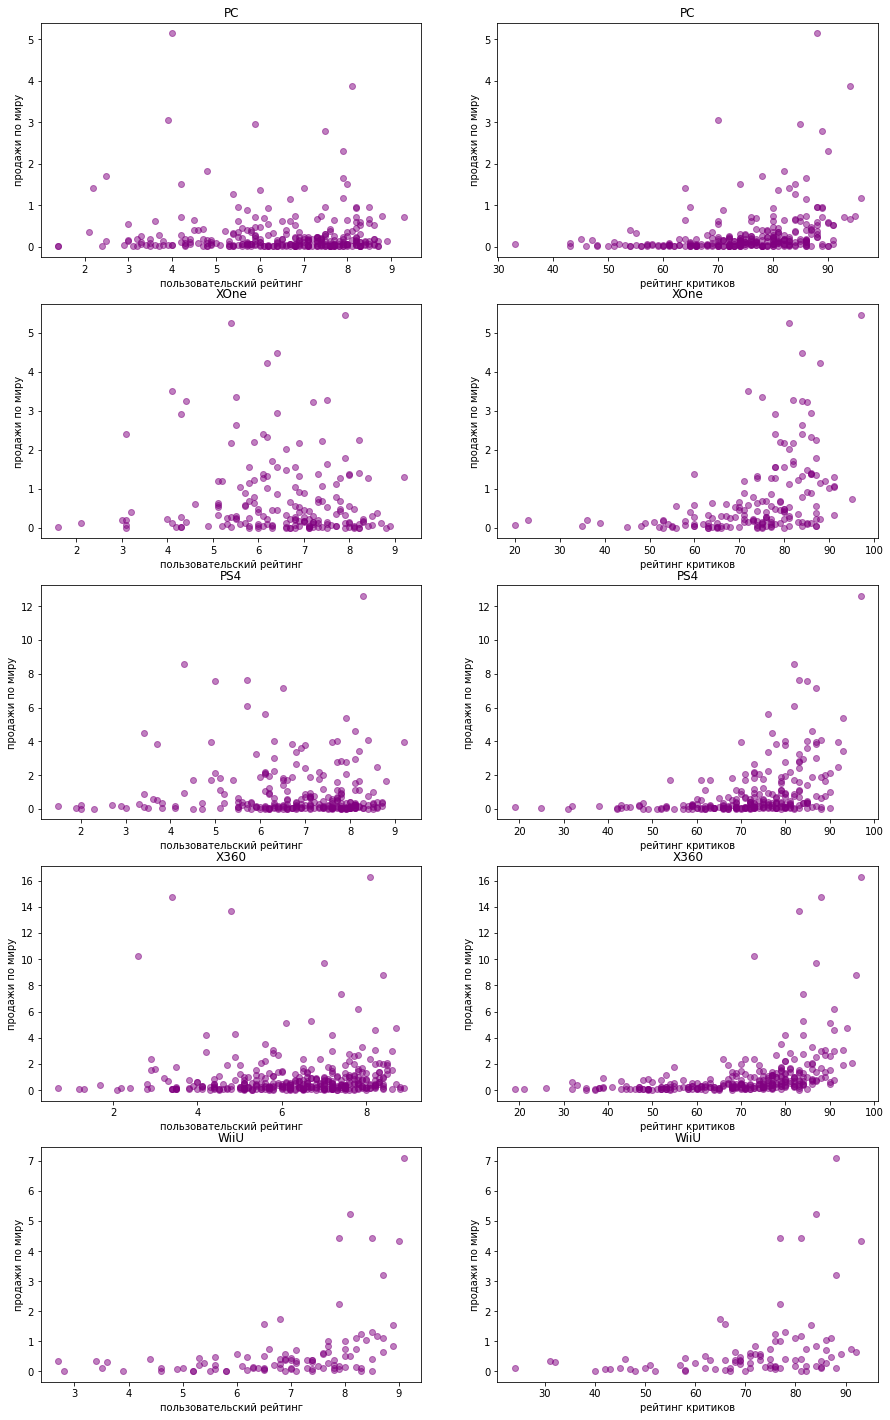

In [34]:
fig, axs = plt.subplots(5, 2, figsize=(15, 25))

list_of_platforms = ['PC', 'XOne', 'PS4', 'X360', 'WiiU']

def draw_plots(i, platform:str):
    axs[i, 0].set_title(platform)
    axs[i, 0].set_xlabel("пользовательский рейтинг")
    axs[i, 0].set_ylabel("продажи по миру")
    axs[i, 0].scatter(df_11_16.query(f"platform == '{platform}'")['user_score'],
                      df_11_16.query(f"platform == '{platform}'")['total_sales'],
                      color='purple',
                      alpha=0.5)
    axs[i, 1].set_title(platform)
    axs[i, 1].set_xlabel("рейтинг критиков")
    axs[i, 1].set_ylabel("продажи по миру")
    axs[i, 1].scatter(df_11_16.query(f"platform == '{platform}'")['critic_score'],
                      df_11_16.query(f"platform == '{platform}'")['total_sales'],
                      color='purple',
                      alpha=0.5)

for i, platform in enumerate(list_of_platforms):
    draw_plots(i, platform)

plt.show()

Зависимость рейтингов и продаж прослеживается, но достаточно сложная:


1.   Между рейтингом пользователя и продажами можно искать связь только у игр платформы WiiU. Эта платформа уходит с рынка, но при пояывлении подобных (например,VR), можно предположить наличие связи.
2.   Хорошие продажи показывают игры с самым разным рейтингом. Здесь можно провести аналогию с популярными фильмами: у многих супергеройских франшиз низкие пользовательские рейтинги; серия фильмов "Сумерки" оценивается пользователями крайне низко, однако популярность подобного кино крайне высокая.
3. Связь рейтинга критиков и продаж есть, но нелинейная: среди игр, низко оценённых критиками, игр с высокими показателями продаж нет; однако высокие продажи (более 2 млн копий по всему миру) имеют только игры, оценённые критиками на 60 и более баллов из 100. Тем не менее, высокая оценка критиков не гарантирует продаж: существенная часть игр имеет высокие оценки, однако продажи не превышают 1 млн копий по миру.


### Определение самых прибыльных жанров

Следующая задача - определить прибыльность жанров.

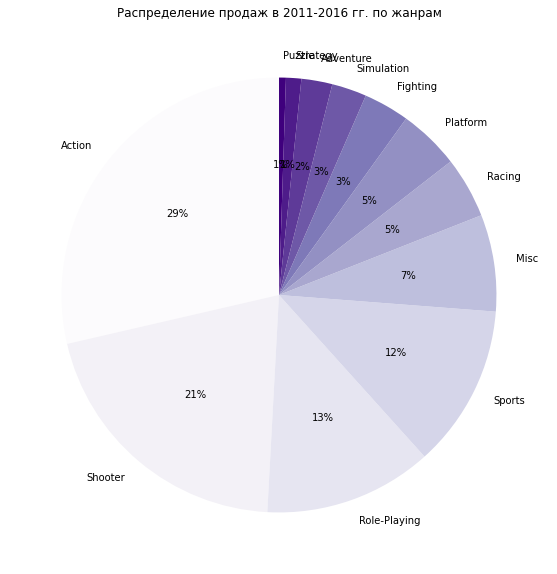

In [35]:
(df_11_16.groupby('genre')['total_sales']
 .sum()
 .sort_values(ascending=False)
 .plot(
     kind='pie',
     figsize=(10, 10),
     autopct='%1.0f%%',
     startangle=90,
     colormap="Purples"))


plt.title('Распределение продаж в 2011-2016 гг. по жанрам')
plt.ylabel('')
plt.show()

Почти половина рынка принадлежит играм в жанре экшн и шутер. Далее следуют RPG и спортивные игры, суммарно с лидерами занимая почти 3/4 рынка. Самые непопулярные по доле продаж жанры - головоломки, квесты и стратегии. Однако такое распределение может быть связано с большим объёмом экшнов и шутеров. Посмотрим на медианный коммерческий успех игр по жанрам:

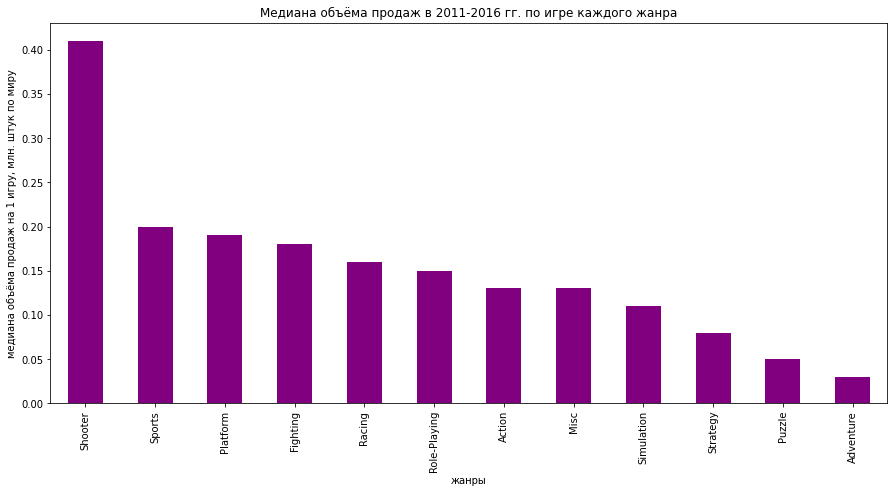

In [36]:
(df_11_16.groupby('genre')['total_sales']
 .median()
 .sort_values(ascending=False)
 .plot(
     kind='bar',
     figsize=(15, 7),
     color="Purple"))


plt.title('Медиана объёма продаж в 2011-2016 гг. по игре каждого жанра')
plt.ylabel('медиана объёма продаж на 1 игру, млн. штук по миру')
plt.xlabel('жанры')
plt.show()

Действительно в лидерах остаются только шутеры и спортивные симуляторы. Экшн экшну рознь: средний коммерческий успех игры такого жанра ниже среднего. Лидируют данные игры за счёт большого количества примеров. А вот аутсайдерами в списке остаются головоломки, стратегии и квесты.

С другой стороны, стоит помнить, что шутеры - это в основном большие релизы, дорогие, разработка которых занимает несколько лет. В то время как паззлы и стратегии - это более простые игры. Для действительного анализа успешности игры необходимо учитывать её бюджет. Имея такие данные, возврат инвестиций у мелких игр может оказаться выше, чем у шутеров.

### Вывод

1.   Рынок классических компьютерных игр развивается динамично. В начале 2000-х происходит развитие 3D-графики, появляются консоли нового поколения, и количество игр ежегодно начинает расти. В конце этого десятилетия на рынке происходят существенные изменения (развитие мобильных игр, компьютерных онлайн-игр), что сокращает объем релизов в год.
2.   Одновременно с сокращением общего количества игр уходят прошлые поколения консолей, на смену им приходят новые. Всё это обуславливает для дальнейшего анализа взять период с 2011 по 2016 год.
3.   Жизнь существенного количества платформ укладывается в период 5-6 лет. Медиана жизненного цикла - 7 лет.
4.   Актуальные на 2017 год платформы - PS4, XOne и 3DS. Первые две находятся на этапе роста, последняя снижает свою долю на рынке, однако по-прежднему занимает существенную часть.
5.   Рейтинги слабо связаны с коммерческим успехом игр. Если игра низко оценена критиками, стоит задуматься о том, чтобы не брать данную игру в рекламную кампанию. Если игра высоко оценена критиками, стоит проанализировать дополнительную информацию. Пользовательские рейтинги с объемами продаж не связаны.
6.   Коммерческий успех среднего шутера примерно в 2 раза выше уровня продаж игры любого другого жанра. Экшны лидируют за счёт большого количества игр, выпускаемых в данном жанре. Не стоит вкладываться в рекламную кампанию игры, в жанре которой указан только puzzle, strategy и adventure.

## Портрет пользователя каждого региона

### Самые популярные платформ

Посмотрим различия в объемах продаж по платформам в каждом регионе.

In [37]:
list_of_headers = ['\nТоп 5 платформ для Северной Америки по суммарному количеству копий игр за 2011-2016 гг.',
                  '\nТоп 5 платформ для Европы по суммарному количеству копий игр за 2011-2016 гг.',
                  '\nТоп 5 платформ для Японии по суммарному количеству копий игр за 2011-2016 гг.']

list_of_columns = ['na_sales', 'eu_sales', 'jp_sales']

def draw_table(header, column):
    print(header)
    display(df_11_16
            .groupby('platform')
            [column]
            .sum()
            .reset_index()
            .sort_values(by=[column], ascending=False)
            .head(5))

for header, column in zip(list_of_headers, list_of_columns):
    draw_table(header, column)


Топ 5 платформ для Северной Америки по суммарному количеству копий игр за 2011-2016 гг.


,platform,na_sales
10,X360,226.80
4,PS3,171.62
5,PS4,108.74
11,XOne,93.12
0,3DS,83.49



Топ 5 платформ для Европы по суммарному количеству копий игр за 2011-2016 гг.


,platform,eu_sales
4,PS3,166.18
5,PS4,141.09
10,X360,117.10
0,3DS,61.48
2,PC,56.70



Топ 5 платформ для Японии по суммарному количеству копий игр за 2011-2016 гг.


,platform,jp_sales
0,3DS,100.67
4,PS3,50.17
6,PSP,24.04
7,PSV,21.91
5,PS4,15.96


Рейтинг платформ существенно различается. В Японии патриотично лидирует 3DS и все виды продукции Sony. В Северной Америке - соответственно в топе обе приставки американской же компании Microsoft.
Европа - единственный регион, где в топе сохраняет свои позиции PC.

### Самые популярные жанры

Посмотрим различия в объемах продаж по жанрам в каждом регионе.

In [38]:
list_of_headers = ['\nТоп 5 жанров для Северной Америки по суммарному количеству копий игр за 2011-2016 гг.',
                  '\nТоп 5 жанров для Европы по суммарному количеству копий игр за 2011-2016 гг.',
                  '\nТоп 5 жанров для Японии по суммарному количеству копий игр за 2011-2016 гг.']

list_of_columns = ['na_sales', 'eu_sales', 'jp_sales']

def draw_table(header, column):
    print(header)
    display(df_11_16
            .groupby('genre')
            [column]
            .sum()
            .reset_index()
            .sort_values(by=[column], ascending=False)
            .head(5))

for header, column in zip(list_of_headers, list_of_columns):
    draw_table(header, column)


Топ 5 жанров для Северной Америки по суммарному количеству копий игр за 2011-2016 гг.


,genre,na_sales
0,Action,232.44
8,Shooter,194.64
10,Sports,108.86
7,Role-Playing,83.89
3,Misc,70.93



Топ 5 жанров для Европы по суммарному количеству копий игр за 2011-2016 гг.


,genre,eu_sales
0,Action,200.57
8,Shooter,148.08
10,Sports,88.83
7,Role-Playing,62.35
6,Racing,41.06



Топ 5 жанров для Японии по суммарному количеству копий игр за 2011-2016 гг.


,genre,jp_sales
7,Role-Playing,80.03
0,Action,64.26
3,Misc,17.60
2,Fighting,12.38
4,Platform,12.13


Топ 4 жанра в Северной Америке и в Европе совпадают. Это экшны, шутеры, спортивные симуляторы и RPG. На пятом месте в США и Канаде игры смешанных жанров, в Европе - гонки. В Японии рейтинг кардинально отличается. RPG на первом месте, далее экшн. Шутеры в Японии не популярны, их место занимают файтеры. Также популярны в Японии игры смешанных жанров и платформеры.

Японский рынок [сильно отличается от мирового](https://vc.ru/finance/192302-osnovnye-cherty-yaponskogo-geymdeva-i-osobennosti-yaponskoy-kultury-povliyavshie-na-nego). Особую значимость имеют персонажи, высокий уровень сервиса и удобства и степени "кавайности" антуража в урон фотореалистичности игрового мира. Запросы жителей других регионов отличаются, что делает японский игровой рынок уникальным.

### Влияение рейтинга ESRB на продажи в отдельном регионе

Каждая игра имеет рейтинг Entertainment Software Rating Board. Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию. Чем строже ограничения игры, тем меньшей аудитории она подходит, что может сказываться на продажах. Посмотрим, какие возрастные рейтинги в нашей усеченной базе 2011-2016 года:

In [39]:
df_11_16['rating'].value_counts()

M       627
T       625
E       623
E10+    460
EC        1
Name: rating, dtype: int64

В базе есть много игр без возрастного рейтинга. Присвоим им категорию N/A. Не будем учитывать коммерческий успех одной игры для младшего возраста, её тоже перекодируем в N/A.

In [40]:
df_11_16['rating'] = df_11_16['rating'].replace('EC','N/A')
df_11_16['rating'] = df_11_16['rating'].fillna('N/A')
df_11_16['rating'].value_counts()

N/A     1721
M        627
T        625
E        623
E10+     460
Name: rating, dtype: int64

Количество игр в возрастных категориях отличается (выделяется E10+), поэтому мы возьмём не суммарные продажи, а средние (медианные слишком близки к нулю для сравнения). Посмотрим на данные.

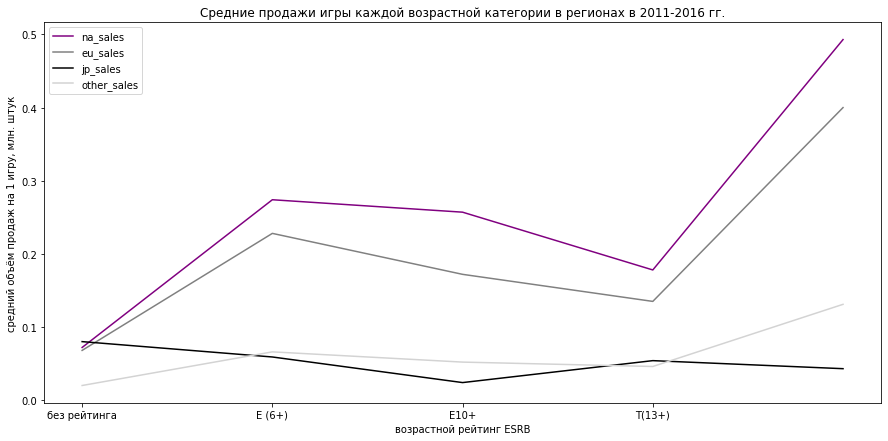

In [41]:
(df_11_16
 .groupby('rating')
 ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
 .mean()
 .round(3)
 .reindex(["N/A", "E", "E10+", "T", "M"])
 .plot(
     figsize=(15, 7),
     color=["purple", 'grey', 'black', 'lightgrey'])
 )

plt.title('Средние продажи игры каждой возрастной категории в регионах в 2011-2016 гг.')
plt.ylabel('средний объём продаж на 1 игру, млн. штук')
plt.xlabel('возрастной рейтинг ESRB')
plt.xticks([0, 1, 2, 3], ['без рейтинга', 'Е (6+)', 'Е10+', 'Т(13+)', 'М(17+)'])
plt.show()

In [42]:
(df_11_16
 .groupby('rating')
 ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
 .mean()
 .round(3)
 .reindex(["N/A", "E", "E10+", "T", "M"]))

,na_sales,eu_sales,jp_sales,other_sales
rating,,,,
N/A,0.072,0.068,0.080,0.020
E,0.274,0.228,0.059,0.066
E10+,0.257,0.172,0.024,0.052
T,0.178,0.135,0.054,0.046
M,0.493,0.400,0.043,0.131


Если смотреть не средние, а медианные или суммарные продажи, то форма графиков не будет отличаться, меняется только относительная позиция игр категории 10+ лет. Также при расчёте медиан пропадают данные по Японии, т.к. продажи там низкие относительно других регионов. Существенны отличия между продажами игр категории Т (13+ лет) и М(17+ лет):
1. Среди всех возрастных категорий и средние, и суммарные и медианные продажи именно игр категории Т (13+ лет) самые низкие.
2. Среди всех возрастных категорий и средние, и суммарные и медианные продажи именно игр категории М (17+ лет) самые высокие.
3. Вышесказанное не относится к играм в Японии. Там продажи примерно на одном уровне по всем категориям. Также разница между играми разных возрастных категорий не очень принципиальна в прочих регионах. В Европе и Северной Америке разница более чем в 2 раза.

Проверим высказанные выводы Т-тестами:

In [43]:
from itertools import combinations

rating_combinations = [i for i in combinations(df_11_16['rating'].unique(), 2)]
num_comb = len(rating_combinations)

alpha = 0.05

for a, b in rating_combinations:
    a_data = df_11_16.loc[df_11_16['rating'] == a, 'total_sales']
    b_data = df_11_16.loc[df_11_16['rating'] == b, 'total_sales']
    _, p_value = st.ttest_ind(a_data, b_data, equal_var=False)
    
    print(p_value)
    if p_value > alpha / num_comb:
        print(f'Между {a} и {b} нет значимых отличий')
    else:
        print(f'Между {a} и {b} ЕСТЬ значимые отличия')

2.8604032392123848e-21
Между M и N/A ЕСТЬ значимые отличия
6.588674575291663e-06
Между M и E ЕСТЬ значимые отличия
7.716475024420098e-10
Между M и E10+ ЕСТЬ значимые отличия
1.3144021104501383e-13
Между M и T ЕСТЬ значимые отличия
2.081409263715699e-11
Между N/A и E ЕСТЬ значимые отличия
1.4984148404932745e-09
Между N/A и E10+ ЕСТЬ значимые отличия
1.896224094730956e-06
Между N/A и T ЕСТЬ значимые отличия
0.06438708626421767
Между E и E10+ нет значимых отличий
0.00039649291536913485
Между E и T ЕСТЬ значимые отличия
0.050061046619402964
Между E10+ и T нет значимых отличий


Т-тесты показывают значимые различия практически во всех случаях, даже в Японии. Таким образом, мы можем утверждать, что возрастные ограничения влияют на уровень продаж.

Однако возрастные ограничения могут играть и опосредованную роль в увеличении или снижении продаж. Посмотрим, одинаково ли распределеяются жанры внутри групп игр по возрастным рейтингам:

In [44]:
pd.crosstab(
    df_11_16['genre'],
    df_11_16['rating'],
    values= df_11_16['genre'],
    aggfunc='count',
    normalize='columns').applymap(lambda x: "{0:.0f}%".format(100*x))

rating,E,E10+,M,N/A,T
genre,,,,,
Action,14%,41%,41%,32%,31%
Adventure,1%,6%,6%,18%,4%
Fighting,0%,1%,3%,3%,14%
Misc,11%,16%,1%,11%,7%
Platform,7%,11%,0%,1%,1%
Puzzle,5%,2%,0%,2%,0%
Racing,15%,5%,0%,3%,3%
Role-Playing,1%,4%,13%,15%,17%
Shooter,0%,5%,34%,3%,7%


Действительно, группы игр по возрастным ограничением неоднородны по жанровому составу. Игры рейтинга М (17+) - это в основном экшн и шутеры, а последние - самые коммерчески успешные игры. Игры для детей от 13 лет - тоже в основном экшны, но шутеров здесь уже почти нет. Посмотрим, есть ли между жанрами и возрастными ограничениями действительная зависимость или значения определены просто распределением большинства (большинство игр - экшны и шутеры).

In [45]:
from scipy.stats import chi2_contingency 
chisqt = pd.crosstab(
    df_11_16['genre'],
    df_11_16['rating'],
    values= df_11_16['genre'],
    aggfunc='count',
    margins=True)

value = np.array([chisqt.iloc[0][0:5].values,
                  chisqt.iloc[1][0:5].values])
print(chi2_contingency(value)[1])

4.153493676410621e-29


Полученный коэффициент p-value подтверждает связь между переменными жанра и возрастных рейтингов (отвергаем нулевую гипотезу о равенстве распределений внутри групп в пользу альтернативной об отличии распределений), поэтому популярность игр категории М(17+) может быть объяснена большим количеством шутеров в данной категории.

### Вывод

1.   Самые популярные платформы - X360 и PS3, которым на смену приходят XOne и PS4. Продукция компании Microsoft более популярна в Северной Америке, продукты Sony - в Японии, т.е. консоли лучше развиваются на домашних рынках. В Японии лидирует 3DS.
2.   Япония в принципе уникальна по характеру рынка видеоигр. Самый популярный жанр здесь - RPG, в топ 5 также в ходят файтеры и нет шутеров. Шутеры и экшн - самые популярные жанры в Северной Америке и Европе.
3.   Возрастные ограничения связаны с продажами игр, как связаны они и с жанрами игр. Самые коммерчески успешные игры - шутеры, а они чаще всего категории 17+. Тем не менее игры с рейтингом М - самые коммерчески привлекательные. Разница между другими возрастными категориями не так принципиальна.

## Проверка гипотез

### Гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC не отличаются.

Критерий оценки связи: если полученное значение p-value будет меньше принятого уровня значимости (0,05), то мы сможем отвергнуть нулевую гипотезу и сказать, что значимые различия среди игр на разных платформах есть. В противном случае мы не сможем утверждать наверняка, равны ли рейтинги или есть значимые различия, т.к. полученные в базе значения могут быть случайны.

Альтернативная гипотеза будет таковой: средние пользовательские рейтинги платформ Xbox One и PC не равны.

In [46]:
alpha = 0.05
print(st.ttest_ind(
    df_11_16.query("platform == 'XOne'")['user_score'].dropna(),
    df_11_16.query("platform == 'PC'")['user_score'].dropna()).pvalue)
pd.pivot_table(df_11_16, index=['platform'], values='user_score', aggfunc={'mean'})

0.6233997626318195


,mean
platform,
3DS,6.832031
DS,6.984375
PC,6.453125
PS2,5.933594
PS3,6.628906
PS4,6.750000
PSP,6.726562
PSV,7.335938
Wii,6.574219


Полученное значение говорит о том, что мы не можем с уверенностью 95% отвергнуть нулевую гипотезу в пользу альтернативной. Рассчитанные средние значения указывают на то, что средние оценки пользователей вообще не сильно отличаются от палтформы к платформе. Немного ниже оценки игр на PS2, немного выше на PSV, но разница - примерно 10%.

### Гипотеза: средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Нулевая гипотеза: средние пользовательские рейтинги жанров экшн и спортивных симуляторов не отличаются.

Критерий оценки связи: если полученное значение p-value будет меньше принятого уровня значимости (0,05), то мы сможем отвергнуть нулевую гипотезу и сказать, что значимые различия среди игр в разных жанрах есть. В противном случае мы не сможем утверждать наверняка, равны ли рейтинги или есть значимые различия, т.к. полученные в базе значения могут быть случайны.

Альтернативная гипотеза будет таковой: средние пользовательские рейтинги жанров экшн и спортивных симуляторов не равны.

In [47]:
alpha = 0.05
print(st.ttest_ind(
    df_11_16.query("genre == 'Action'")['user_score'].dropna(),
    df_11_16.query("genre == 'Sports'")['user_score'].dropna()).pvalue)
pd.pivot_table(df_11_16, index=['genre'], values='user_score', aggfunc={'mean'})

3.064880271017331e-24


,mean
genre,
Action,6.781250
Adventure,7.367188
Fighting,6.871094
Misc,6.851562
Platform,6.933594
Puzzle,7.234375
Racing,6.253906
Role-Playing,7.261719
Shooter,6.417969


Полученное значение говорит о том, что мы с уверенностью 95% можем отвергнуть нулевую гипотезу в пользу альтернативной. Рассчитанные средние значения указывают на то, что пользователи выше ценят квесты, головоломки и RPG, и ниже - как раз спортивные симуляторы. Разница также не выглядит драматичной, но т-тест показывает значимость различий между оценками спортивных симуляторов и экшнов.

### Вывод

1.   Мы не нашли значимых различий между пользовательскими рейтингами игр на PC и X-Box One.
2.   Различия пользовательских рейтингов экшн-игр и спортивных симуляторов оказались принципиальны.

## Общий вывод

Основной исследовательской задачей было выявить определяющие коммерческую успешность игр закономерности, которые помогут спланировать рекламную кампанию на 2017 год:
1.   Наиболее коммерчески успешные игры - шутеры. Они же игры 17+. Есть смысл вкладываться в их продвижение в будущем.
2.   Срок жизни платформы - 5-7 лет. В 2017 году будут актуальны 3DS (уходит с рынка), PS4 (лидирует на рынке и растёт), X-Box One (растёт). Стоит продвигать игры на этих платформах.
3.   Отзывы пользователей - не показатель коммерческой успешности. Стоит обращать внимание на отзывы критиков. Есть отзывы критиков положительные, игра может показать хорошие продажи. Если оценки критиков низкие, игра точно покажет низкие продажи.

В 2017 году рекомендуется:
1.   В первую очередь продвигать игры на PS4, во вторую - на X-Box One. Анализировать продажи по платформам в динамике.
2.   Если в жанре иргы указан шутер, её стоит брать в рекламную кампанию.
3.   Если игра получила низкие оценки критиков (менее 60 из 100), стоит отказаться от её рекламирования.